In [152]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import optuna

warnings.filterwarnings('ignore')

In [3]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X

In [129]:
df = pd.concat([
    pd.read_csv('train.csv'),
    pd.read_csv('test.csv')],
    axis=0,ignore_index=True)
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

In [130]:
X = preprocessing.vectorize_tfidf(df)

In [131]:
X = pd.concat([df.jobflag, X], axis=1)

In [132]:
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

In [9]:
train_X = train_df.drop(columns=['jobflag'])
train_y = train_df['jobflag']-1

In [10]:
PARAMS={'boosting_type': 'gbdt','objective': 'multiclass','metric': 'multiclass', 'num_class':4,
                'max_bin': 100,'n_estimators': 1400,'boost_from_average': False,'verbose': -1,'random_state':2020,
                'subsample': 0.8897026631967412, 'subsample_freq': 0.42708068942389565,
                'learning_rate': 0.030223062885783494,'num_leaves': 66, 'feature_fraction': 0.4294129948533598,
                'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l2': 6.563593012634628}

In [31]:
k = StratifiedKFold(n_splits=5)
score=[]
importance=[]
for _ in range(5):
    for trn, val in k.split(train_X, train_y):
        trn_X, val_X = train_X.iloc[trn,:], train_X.iloc[val,:]
        trn_y, val_y = train_y.iloc[trn].astype(int), train_y.iloc[val].astype(int)
        train_set = lgb.Dataset(trn_X, trn_y)
        val_set = lgb.Dataset(val_X, val_y)

        PARAMS['random_state']+=1
        model = lgb.train(params=PARAMS, train_set=train_set, valid_sets=val_set,
                  num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
        preds = model.predict(val_X)
        score.append(metrics.f1_score(val_y,  np.argmax(preds, axis=1), average='macro'))
        importance.append(model.feature_importance('gain'))

Training until validation scores don't improve for 200 rounds
[500]	valid_0's multi_logloss: 0.940099
Early stopping, best iteration is:
[303]	valid_0's multi_logloss: 0.916964
Training until validation scores don't improve for 200 rounds
[500]	valid_0's multi_logloss: 0.867486
Early stopping, best iteration is:
[326]	valid_0's multi_logloss: 0.85594
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.895986
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[271]	valid_0's multi_logloss: 0.901935
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[245]	valid_0's multi_logloss: 0.933606
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 0.917643
Training until validation scores don't improve for 200 rounds
[500]	valid_0's multi_logloss: 0.8653

In [32]:
print(score)

[0.5721308335543317, 0.587373547182722, 0.5850532866560626, 0.5680506919858384, 0.5477196589738642, 0.586552923536601, 0.5955935522602498, 0.5746599884034954, 0.5620702145562652, 0.5346557650809112, 0.5837086797322876, 0.6012835318630245, 0.5855989220829593, 0.5659571674663972, 0.5478146021495741, 0.5825551399795144, 0.5945813105653999, 0.5784790265597044, 0.5744838867783698, 0.5522052976361169, 0.5762968578437637, 0.5919576373542771, 0.5734348976860227, 0.5639818779097625, 0.5431023134518309]


In [35]:
importance_df=pd.DataFrame()
importance_df['col'] = trn_X.columns
importance_df['mean_value'] = np.mean(importance, axis=0)
importance_df['std_value'] = np.std(importance, axis=0)
importance_df['mean_std'] = importance_df.mean_value/importance_df.std_value

In [45]:
importance_df.dropna(axis=0).sort_values('mean_std').tail(10)

,col,mean_value,std_value,mean_std
2215,platform,153.569114,12.658364,12.131830
395,build,574.373455,46.677902,12.305040
2527,requir,716.783795,57.460093,12.474463
1017,engin,590.557183,45.622791,12.944346
165,analysi,651.556710,49.997822,13.031702
2788,softwar,1737.749911,133.208126,13.045375
3001,technolog,280.252852,20.746983,13.508126
1889,model,1893.872131,122.978244,15.400058
752,data,5809.819357,346.176349,16.782832
1767,machinelearn,2956.043602,106.734357,27.695333


In [63]:
class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        self._objective = _objective
        
    def objective(self, trial):
        
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt','objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        
            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            model = lgb.train(train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                                  early_stopping_rounds=200, verbose_eval=500)
            
            preds = model.predict(val_df[self.features])
            score+=metrics.f1_score(val_df[self.target],  np.argmax(preds, axis=1), average='macro')/5
            
        return score

In [79]:
def make_null_importance_df(train_X, train_y, PARAMS):
    k = StratifiedKFold(n_splits=5)
    null_importance=pd.DataFrame()
    null_importance['col'] = train_X.columns.tolist()
    for i in range(50):
        tmp_null_importance=[]
        train_y = train_y.sample(frac=1).reset_index(drop=True)
        for trn, val in k.split(train_X, train_y):
            trn_X, val_X = train_X.iloc[trn,:], train_X.iloc[val,:]
            trn_y, val_y = train_y.iloc[trn].astype(int), train_y.iloc[val].astype(int)
            train_set = lgb.Dataset(trn_X, trn_y)
            val_set = lgb.Dataset(val_X, val_y)

            PARAMS['random_state']+=1
            model = lgb.train(params=PARAMS, train_set=train_set, valid_sets=val_set,
                              num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
            preds = model.predict(val_X)
            tmp_null_importance.append(model.feature_importance('gain'))
        null_importance[f'null_importance_{i+1}'] = np.mean(tmp_null_importance, axis=0)
    return null_importance

In [64]:
train_df['jobflag_2']=train_df['jobflag']-1
feature = train_df.drop(columns=['jobflag', 'jobflag_2']).columns
warnings.filterwarnings('ignore')
optimize_optuna = Optimize_by_Optuna(train_df, feature, 'jobflag_2')
study = optuna.create_study(direction='maximize')
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.846886	valid_1's multi_logloss: 0.979166
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.834862	valid_1's multi_logloss: 0.917611
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.753782	valid_1's multi_logloss: 0.931882
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.806679	valid_1's multi_logloss: 0.923847
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.876579	valid_1's multi_logloss: 0.956095
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.833396	valid_1's multi_logloss: 0.992638


[I 2020-08-19 09:54:02,344] Finished trial#0 resulted in value: 0.5136647544062923. Current best value is 0.5136647544062923 with parameters: {'max_bin': 174, 'subsample': 0.4553265394271921, 'subsample_freq': 0.4713956298132341, 'learning_rate': 0.09310877680319456, 'num_leaves': 5, 'feature_fraction': 0.771408088717868, 'bagging_freq': 4, 'min_child_samples': 39, 'lambda_l1': 0.0012021037249102368, 'lambda_l2': 3.587201619585713}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.828659	valid_1's multi_logloss: 0.977006
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.850366	valid_1's multi_logloss: 0.938193
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.782332	valid_1's multi_logloss: 0.921713
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.855853	valid_1's multi_logloss: 0.957747
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.876406	valid_1's multi_logloss: 0.996609


[I 2020-08-19 09:54:21,198] Finished trial#1 resulted in value: 0.5234715206750775. Current best value is 0.5234715206750775 with parameters: {'max_bin': 188, 'subsample': 0.7784749140029616, 'subsample_freq': 0.7361616312962526, 'learning_rate': 0.09340366216389537, 'num_leaves': 9, 'feature_fraction': 0.5407232401378954, 'bagging_freq': 7, 'min_child_samples': 75, 'lambda_l1': 0.004671997307473328, 'lambda_l2': 0.17971976931129194}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.901835	valid_1's multi_logloss: 1.00043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.924974	valid_1's multi_logloss: 0.95064
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.9191	valid_1's multi_logloss: 0.947515
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.916824	valid_1's multi_logloss: 0.967056
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.875334	valid_1's multi_logloss: 1.00581


[I 2020-08-19 09:54:37,901] Finished trial#2 resulted in value: 0.5084847412927261. Current best value is 0.5234715206750775 with parameters: {'max_bin': 188, 'subsample': 0.7784749140029616, 'subsample_freq': 0.7361616312962526, 'learning_rate': 0.09340366216389537, 'num_leaves': 9, 'feature_fraction': 0.5407232401378954, 'bagging_freq': 7, 'min_child_samples': 75, 'lambda_l1': 0.004671997307473328, 'lambda_l2': 0.17971976931129194}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.827158	valid_1's multi_logloss: 0.981048
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.794841	valid_1's multi_logloss: 0.935763
Early stopping, best iteration is:
[380]	training's multi_logloss: 0.821711	valid_1's multi_logloss: 0.931962
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[275]	training's multi_logloss: 0.840875	valid_1's multi_logloss: 0.918579
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's multi_logloss: 0.833643	valid_1's multi_logloss: 0.954272
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.849482	valid_1's multi_logloss: 0.994024


[I 2020-08-19 09:54:57,536] Finished trial#3 resulted in value: 0.5221328283982394. Current best value is 0.5234715206750775 with parameters: {'max_bin': 188, 'subsample': 0.7784749140029616, 'subsample_freq': 0.7361616312962526, 'learning_rate': 0.09340366216389537, 'num_leaves': 9, 'feature_fraction': 0.5407232401378954, 'bagging_freq': 7, 'min_child_samples': 75, 'lambda_l1': 0.004671997307473328, 'lambda_l2': 0.17971976931129194}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.81559	valid_1's multi_logloss: 1.00821
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's multi_logloss: 0.878359	valid_1's multi_logloss: 0.977068
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.817897	valid_1's multi_logloss: 0.970168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's multi_logloss: 0.864326	valid_1's multi_logloss: 0.960929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's multi_logloss: 0.883283	valid_1's multi_logloss: 1.01953


[I 2020-08-19 09:55:14,821] Finished trial#4 resulted in value: 0.49601206282037136. Current best value is 0.5234715206750775 with parameters: {'max_bin': 188, 'subsample': 0.7784749140029616, 'subsample_freq': 0.7361616312962526, 'learning_rate': 0.09340366216389537, 'num_leaves': 9, 'feature_fraction': 0.5407232401378954, 'bagging_freq': 7, 'min_child_samples': 75, 'lambda_l1': 0.004671997307473328, 'lambda_l2': 0.17971976931129194}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.813356	valid_1's multi_logloss: 0.985967
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's multi_logloss: 0.809768	valid_1's multi_logloss: 0.909975
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's multi_logloss: 0.843638	valid_1's multi_logloss: 0.930255
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[16]	training's multi_logloss: 0.887068	valid_1's multi_logloss: 0.965287
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[17]	training's multi_logloss: 0.869058	valid_1's multi_logloss: 1.00089


[I 2020-08-19 09:55:31,750] Finished trial#5 resulted in value: 0.5183675194057343. Current best value is 0.5234715206750775 with parameters: {'max_bin': 188, 'subsample': 0.7784749140029616, 'subsample_freq': 0.7361616312962526, 'learning_rate': 0.09340366216389537, 'num_leaves': 9, 'feature_fraction': 0.5407232401378954, 'bagging_freq': 7, 'min_child_samples': 75, 'lambda_l1': 0.004671997307473328, 'lambda_l2': 0.17971976931129194}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's multi_logloss: 0.721186	valid_1's multi_logloss: 0.948879
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.701248	valid_1's multi_logloss: 0.869724
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.746445	valid_1's multi_logloss: 0.900163
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.746279	valid_1's multi_logloss: 0.922053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.71961	valid_1's multi_logloss: 0.944994


[I 2020-08-19 09:55:54,175] Finished trial#6 resulted in value: 0.5513119530963412. Current best value is 0.5513119530963412 with parameters: {'max_bin': 162, 'subsample': 0.7937495497680944, 'subsample_freq': 0.49432407815786517, 'learning_rate': 0.04199859381303744, 'num_leaves': 9, 'feature_fraction': 0.6642154811630074, 'bagging_freq': 1, 'min_child_samples': 29, 'lambda_l1': 0.004684359888254445, 'lambda_l2': 0.0007273376379007983}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.69513	valid_1's multi_logloss: 0.93945
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.643696	valid_1's multi_logloss: 0.865242
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.692699	valid_1's multi_logloss: 0.893066
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[288]	training's multi_logloss: 0.638125	valid_1's multi_logloss: 0.903665
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.661755	valid_1's multi_logloss: 0.935153


[I 2020-08-19 09:56:19,544] Finished trial#7 resulted in value: 0.5645978742059273. Current best value is 0.5645978742059273 with parameters: {'max_bin': 191, 'subsample': 0.8997939664617591, 'subsample_freq': 0.801197919558142, 'learning_rate': 0.08032365156565872, 'num_leaves': 6, 'feature_fraction': 0.7468428828858379, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 0.0007886053617124732, 'lambda_l2': 1.813299381413606}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.703555	valid_1's multi_logloss: 0.937251
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.638757	valid_1's multi_logloss: 0.873465
Early stopping, best iteration is:
[363]	training's multi_logloss: 0.67601	valid_1's multi_logloss: 0.865752
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.69592	valid_1's multi_logloss: 0.895503
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.749398	valid_1's multi_logloss: 0.913232
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.678815	valid_1's multi_logloss: 0.954677


[I 2020-08-19 09:56:53,295] Finished trial#8 resulted in value: 0.5633048990286063. Current best value is 0.5645978742059273 with parameters: {'max_bin': 191, 'subsample': 0.8997939664617591, 'subsample_freq': 0.801197919558142, 'learning_rate': 0.08032365156565872, 'num_leaves': 6, 'feature_fraction': 0.7468428828858379, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 0.0007886053617124732, 'lambda_l2': 1.813299381413606}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.657279	valid_1's multi_logloss: 0.941821
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's multi_logloss: 0.59737	valid_1's multi_logloss: 0.866124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.633169	valid_1's multi_logloss: 0.889523
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.644973	valid_1's multi_logloss: 0.91334
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.645555	valid_1's multi_logloss: 0.939253


[I 2020-08-19 09:57:20,319] Finished trial#9 resulted in value: 0.5606711412601612. Current best value is 0.5645978742059273 with parameters: {'max_bin': 191, 'subsample': 0.8997939664617591, 'subsample_freq': 0.801197919558142, 'learning_rate': 0.08032365156565872, 'num_leaves': 6, 'feature_fraction': 0.7468428828858379, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 0.0007886053617124732, 'lambda_l2': 1.813299381413606}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.869354	valid_1's multi_logloss: 0.987429
Early stopping, best iteration is:
[452]	training's multi_logloss: 0.875076	valid_1's multi_logloss: 0.986719
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.902215	valid_1's multi_logloss: 0.9653
Early stopping, best iteration is:
[467]	training's multi_logloss: 0.906359	valid_1's multi_logloss: 0.964072
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.904309	valid_1's multi_logloss: 0.946108
Early stopping, best iteration is:
[783]	training's multi_logloss: 0.877382	valid_1's multi_logloss: 0.940187
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.881657	valid_1's multi_logloss: 0.94786
[1000]	training's multi_logloss: 0.837755	valid_1's multi_logloss: 0.948117
Early stopping, best iteration is:
[833]	training

[I 2020-08-19 09:57:45,042] Finished trial#10 resulted in value: 0.5075908213134612. Current best value is 0.5645978742059273 with parameters: {'max_bin': 191, 'subsample': 0.8997939664617591, 'subsample_freq': 0.801197919558142, 'learning_rate': 0.08032365156565872, 'num_leaves': 6, 'feature_fraction': 0.7468428828858379, 'bagging_freq': 6, 'min_child_samples': 17, 'lambda_l1': 0.0007886053617124732, 'lambda_l2': 1.813299381413606}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.668502	valid_1's multi_logloss: 0.931222
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	training's multi_logloss: 0.607637	valid_1's multi_logloss: 0.870616
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.673923	valid_1's multi_logloss: 0.895166
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.679205	valid_1's multi_logloss: 0.904635
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.729665	valid_1's multi_logloss: 0.952256


[I 2020-08-19 09:58:09,167] Finished trial#11 resulted in value: 0.5647352759489483. Current best value is 0.5647352759489483 with parameters: {'max_bin': 93, 'subsample': 0.6180385169517516, 'subsample_freq': 0.8610897150141679, 'learning_rate': 0.20561320268661615, 'num_leaves': 7, 'feature_fraction': 0.7509854419633061, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 0.3838070525553391, 'lambda_l2': 1.5547679269374035}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	training's multi_logloss: 0.7766	valid_1's multi_logloss: 0.949658
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.702576	valid_1's multi_logloss: 0.879731
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.750112	valid_1's multi_logloss: 0.903309
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.769127	valid_1's multi_logloss: 0.921157
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.768434	valid_1's multi_logloss: 0.96071


[I 2020-08-19 09:58:31,767] Finished trial#12 resulted in value: 0.5538220480336903. Current best value is 0.5647352759489483 with parameters: {'max_bin': 93, 'subsample': 0.6180385169517516, 'subsample_freq': 0.8610897150141679, 'learning_rate': 0.20561320268661615, 'num_leaves': 7, 'feature_fraction': 0.7509854419633061, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 0.3838070525553391, 'lambda_l2': 1.5547679269374035}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.653948	valid_1's multi_logloss: 0.925998
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.555199	valid_1's multi_logloss: 0.858244
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's multi_logloss: 0.633823	valid_1's multi_logloss: 0.874183
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.634956	valid_1's multi_logloss: 0.89076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.643252	valid_1's multi_logloss: 0.93142


[I 2020-08-19 09:58:59,665] Finished trial#13 resulted in value: 0.5684378408806294. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.805408	valid_1's multi_logloss: 0.963965
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.765481	valid_1's multi_logloss: 0.904542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.803969	valid_1's multi_logloss: 0.921217
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's multi_logloss: 0.825897	valid_1's multi_logloss: 0.943606
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.842997	valid_1's multi_logloss: 0.991862


[I 2020-08-19 09:59:20,548] Finished trial#14 resulted in value: 0.5269294140397391. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.652159	valid_1's multi_logloss: 0.927475
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.61495	valid_1's multi_logloss: 0.867466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.717499	valid_1's multi_logloss: 0.885968
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.667571	valid_1's multi_logloss: 0.896164
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[203]	training's multi_logloss: 0.583516	valid_1's multi_logloss: 0.956158


[I 2020-08-19 09:59:43,853] Finished trial#15 resulted in value: 0.5595437641577545. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.792826	valid_1's multi_logloss: 0.963884
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.774358	valid_1's multi_logloss: 0.911788
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.762122	valid_1's multi_logloss: 0.931488
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	training's multi_logloss: 0.813702	valid_1's multi_logloss: 0.931048
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.858472	valid_1's multi_logloss: 0.974459


[I 2020-08-19 10:00:03,011] Finished trial#16 resulted in value: 0.536518214172033. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.961347	valid_1's multi_logloss: 1.07214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.983204	valid_1's multi_logloss: 1.06331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.965747	valid_1's multi_logloss: 1.01564
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.974652	valid_1's multi_logloss: 1.04492
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.936973	valid_1's multi_logloss: 1.08319


[I 2020-08-19 10:00:24,995] Finished trial#17 resulted in value: 0.4084625377561578. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.730936	valid_1's multi_logloss: 0.950762
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.654299	valid_1's multi_logloss: 0.863043
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.687668	valid_1's multi_logloss: 0.898849
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.732448	valid_1's multi_logloss: 0.910503
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.708576	valid_1's multi_logloss: 0.941814


[I 2020-08-19 10:00:46,050] Finished trial#18 resulted in value: 0.5620762166362253. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.806793	valid_1's multi_logloss: 0.967131
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.775201	valid_1's multi_logloss: 0.910426
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.824721	valid_1's multi_logloss: 0.924125
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.812549	valid_1's multi_logloss: 0.939277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's multi_logloss: 0.863223	valid_1's multi_logloss: 0.987497


[I 2020-08-19 10:01:05,099] Finished trial#19 resulted in value: 0.5270683474300356. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.738267	valid_1's multi_logloss: 0.940218
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.651737	valid_1's multi_logloss: 0.871279
Early stopping, best iteration is:
[454]	training's multi_logloss: 0.659412	valid_1's multi_logloss: 0.869092
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.638073	valid_1's multi_logloss: 0.896133
Early stopping, best iteration is:
[376]	training's multi_logloss: 0.678359	valid_1's multi_logloss: 0.890368
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.723092	valid_1's multi_logloss: 0.921347
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.636056	valid_1's multi_logloss: 0.952904
Early stopping, best iter

[I 2020-08-19 10:01:31,216] Finished trial#20 resulted in value: 0.5530716410556716. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.605072	valid_1's multi_logloss: 0.953047
Early stopping, best iteration is:
[323]	training's multi_logloss: 0.681332	valid_1's multi_logloss: 0.942229
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.624433	valid_1's multi_logloss: 0.865743
Early stopping, best iteration is:
[434]	training's multi_logloss: 0.649787	valid_1's multi_logloss: 0.864861
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.621347	valid_1's multi_logloss: 0.898094
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.654417	valid_1's multi_logloss: 0.892701
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.714906	valid_1's multi_logloss: 0.90087
Training until validation scores don't improve for 200 rounds
[500]	training's multi_log

[I 2020-08-19 10:01:58,296] Finished trial#21 resulted in value: 0.5622091311879136. Current best value is 0.5684378408806294 with parameters: {'max_bin': 105, 'subsample': 0.8948870829556534, 'subsample_freq': 0.8057627462502415, 'learning_rate': 0.19620976053628095, 'num_leaves': 6, 'feature_fraction': 0.9603776263585633, 'bagging_freq': 1, 'min_child_samples': 5, 'lambda_l1': 0.762542067224131, 'lambda_l2': 0.9953356748681305}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.461157	valid_1's multi_logloss: 0.933354
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.550303	valid_1's multi_logloss: 0.918171
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.477725	valid_1's multi_logloss: 0.861235
Early stopping, best iteration is:
[314]	training's multi_logloss: 0.578991	valid_1's multi_logloss: 0.855331
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.633004	valid_1's multi_logloss: 0.868048
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[279]	training's multi_logloss: 0.595467	valid_1's multi_logloss: 0.889559
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.5779	valid_1's multi_logloss: 0

[I 2020-08-19 10:02:25,850] Finished trial#22 resulted in value: 0.5794519352505282. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.579225	valid_1's multi_logloss: 0.92079
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.615459	valid_1's multi_logloss: 0.857728
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.609447	valid_1's multi_logloss: 0.872839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.548247	valid_1's multi_logloss: 0.883039
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.536857	valid_1's multi_logloss: 0.92431


[I 2020-08-19 10:02:50,404] Finished trial#23 resulted in value: 0.5781034525813775. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.769205	valid_1's multi_logloss: 0.945877
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.742861	valid_1's multi_logloss: 0.869064
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	training's multi_logloss: 0.744876	valid_1's multi_logloss: 0.904582
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.737919	valid_1's multi_logloss: 0.911364
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.770876	valid_1's multi_logloss: 0.952059


[I 2020-08-19 10:03:10,734] Finished trial#24 resulted in value: 0.5501877626848254. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.604461	valid_1's multi_logloss: 0.912284
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.487204	valid_1's multi_logloss: 0.858419
Early stopping, best iteration is:
[364]	training's multi_logloss: 0.563989	valid_1's multi_logloss: 0.855695
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.609142	valid_1's multi_logloss: 0.864963
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.4832	valid_1's multi_logloss: 0.890007
Early stopping, best iteration is:
[457]	training's multi_logloss: 0.504481	valid_1's multi_logloss: 0.886195
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[296]	training's multi_logloss: 0.59394	valid_1's multi_logloss: 0.

[I 2020-08-19 10:03:38,531] Finished trial#25 resulted in value: 0.5790369093588645. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.593573	valid_1's multi_logloss: 0.957883
Early stopping, best iteration is:
[301]	training's multi_logloss: 0.687039	valid_1's multi_logloss: 0.94039
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.611551	valid_1's multi_logloss: 0.871768
Early stopping, best iteration is:
[361]	training's multi_logloss: 0.67268	valid_1's multi_logloss: 0.863545
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.609854	valid_1's multi_logloss: 0.901148
Early stopping, best iteration is:
[342]	training's multi_logloss: 0.682638	valid_1's multi_logloss: 0.881749
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.60531	valid_1's multi_logloss: 0.910467
Early stopping, best iteration is:
[312]	training's multi_logloss: 0.692035	valid_1's multi_logloss: 0.903104
Training until 

[I 2020-08-19 10:04:02,454] Finished trial#26 resulted in value: 0.5626129893018688. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.650883	valid_1's multi_logloss: 0.956005
Early stopping, best iteration is:
[313]	training's multi_logloss: 0.727195	valid_1's multi_logloss: 0.942335
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.672813	valid_1's multi_logloss: 0.86143
Early stopping, best iteration is:
[518]	training's multi_logloss: 0.667107	valid_1's multi_logloss: 0.860733
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.665475	valid_1's multi_logloss: 0.909863
Early stopping, best iteration is:
[381]	training's multi_logloss: 0.712083	valid_1's multi_logloss: 0.900447
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.660007	valid_1's multi_logloss: 0.920849
Early stopping, best iteration is:
[336]	training's multi_logloss: 0.725778	valid_1's multi_logloss: 0.913666
Training unti

[I 2020-08-19 10:04:30,893] Finished trial#27 resulted in value: 0.5647063689097287. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.723238	valid_1's multi_logloss: 0.944166
Early stopping, best iteration is:
[590]	training's multi_logloss: 0.705474	valid_1's multi_logloss: 0.940554
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.742097	valid_1's multi_logloss: 0.869209
Early stopping, best iteration is:
[795]	training's multi_logloss: 0.692841	valid_1's multi_logloss: 0.864258
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.738182	valid_1's multi_logloss: 0.896987
Early stopping, best iteration is:
[622]	training's multi_logloss: 0.714095	valid_1's multi_logloss: 0.895739
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.732732	valid_1's multi_logloss: 0.907564
Early stopping, best iteration is:
[557]	training's multi_logloss: 0.720706	valid_1's multi_logloss: 0.90275
Training unti

[I 2020-08-19 10:05:00,129] Finished trial#28 resulted in value: 0.5521029585104139. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.770613	valid_1's multi_logloss: 0.958057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.708966	valid_1's multi_logloss: 0.877212
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.768921	valid_1's multi_logloss: 0.911165
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.797825	valid_1's multi_logloss: 0.917552
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.770962	valid_1's multi_logloss: 0.949941


[I 2020-08-19 10:05:22,012] Finished trial#29 resulted in value: 0.5408650548236813. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	training's multi_logloss: 0.806121	valid_1's multi_logloss: 0.964352
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.705164	valid_1's multi_logloss: 0.921545
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.761062	valid_1's multi_logloss: 0.907225
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.770216	valid_1's multi_logloss: 0.916694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.812991	valid_1's multi_logloss: 0.940974
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.786893	valid_1's multi_logloss: 0.979148


[I 2020-08-19 10:05:42,892] Finished trial#30 resulted in value: 0.534979799606582. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[246]	training's multi_logloss: 0.639587	valid_1's multi_logloss: 0.925497
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.511054	valid_1's multi_logloss: 0.857227
Early stopping, best iteration is:
[520]	training's multi_logloss: 0.502498	valid_1's multi_logloss: 0.856432
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[299]	training's multi_logloss: 0.618443	valid_1's multi_logloss: 0.87475
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.619609	valid_1's multi_logloss: 0.884315
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.492365	valid_1's multi_logloss: 0.938791
Early stopping, best iteration is:
[371]	training's multi_logloss: 0.555854	valid_1's multi_logloss: 

[I 2020-08-19 10:06:11,898] Finished trial#31 resulted in value: 0.5733739109610626. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.65139	valid_1's multi_logloss: 0.929308
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.618689	valid_1's multi_logloss: 0.859955
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.660393	valid_1's multi_logloss: 0.881688
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.668332	valid_1's multi_logloss: 0.895462
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.650077	valid_1's multi_logloss: 0.92456


[I 2020-08-19 10:06:41,796] Finished trial#32 resulted in value: 0.5719520933026025. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.58888	valid_1's multi_logloss: 0.937657
Early stopping, best iteration is:
[311]	training's multi_logloss: 0.653234	valid_1's multi_logloss: 0.930116
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.60567	valid_1's multi_logloss: 0.855209
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.607355	valid_1's multi_logloss: 0.854175
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.700659	valid_1's multi_logloss: 0.880452
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.699657	valid_1's multi_logloss: 0.896248
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.588924	valid_1's multi_logloss: 0.950542
Early stopping, best iterat

[I 2020-08-19 10:07:11,976] Finished trial#33 resulted in value: 0.5721856191572441. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.667592	valid_1's multi_logloss: 0.947083
Early stopping, best iteration is:
[328]	training's multi_logloss: 0.730498	valid_1's multi_logloss: 0.940805
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.691511	valid_1's multi_logloss: 0.860838
Early stopping, best iteration is:
[571]	training's multi_logloss: 0.671017	valid_1's multi_logloss: 0.859806
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.682203	valid_1's multi_logloss: 0.898781
Early stopping, best iteration is:
[391]	training's multi_logloss: 0.719951	valid_1's multi_logloss: 0.893932
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.677216	valid_1's multi_logloss: 0.918692
Early stopping, best iteration is:
[388]	training's multi_logloss: 0.715637	valid_1's multi_logloss: 0.911791
Training unt

[I 2020-08-19 10:07:39,038] Finished trial#34 resulted in value: 0.564042732670442. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.857165	valid_1's multi_logloss: 0.98194
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.812037	valid_1's multi_logloss: 0.955713
Early stopping, best iteration is:
[314]	training's multi_logloss: 0.849947	valid_1's multi_logloss: 0.94917
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.842022	valid_1's multi_logloss: 0.92416
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.855909	valid_1's multi_logloss: 0.947741
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.869933	valid_1's multi_logloss: 0.996785


[I 2020-08-19 10:07:57,754] Finished trial#35 resulted in value: 0.5183748005859483. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.822006	valid_1's multi_logloss: 0.978862
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's multi_logloss: 0.792164	valid_1's multi_logloss: 0.915328
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.838727	valid_1's multi_logloss: 0.927146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.823664	valid_1's multi_logloss: 0.94884
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.866481	valid_1's multi_logloss: 0.987274


[I 2020-08-19 10:08:18,441] Finished trial#36 resulted in value: 0.5245337019098539. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[230]	training's multi_logloss: 0.616821	valid_1's multi_logloss: 0.931291
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.662761	valid_1's multi_logloss: 0.860316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[171]	training's multi_logloss: 0.690415	valid_1's multi_logloss: 0.894399
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.658484	valid_1's multi_logloss: 0.888023
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[249]	training's multi_logloss: 0.605373	valid_1's multi_logloss: 0.927709


[I 2020-08-19 10:09:01,010] Finished trial#37 resulted in value: 0.5731004990750678. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.732231	valid_1's multi_logloss: 0.941112
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.621068	valid_1's multi_logloss: 0.866097
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	training's multi_logloss: 0.714683	valid_1's multi_logloss: 0.884269
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.724823	valid_1's multi_logloss: 0.906985
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.645617	valid_1's multi_logloss: 0.936204


[I 2020-08-19 10:09:33,592] Finished trial#38 resulted in value: 0.5604181820807861. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.91468	valid_1's multi_logloss: 0.993406
[1000]	training's multi_logloss: 0.881843	valid_1's multi_logloss: 0.980679
Did not meet early stopping. Best iteration is:
[1400]	training's multi_logloss: 0.865219	valid_1's multi_logloss: 0.975587
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.92788	valid_1's multi_logloss: 0.949116
[1000]	training's multi_logloss: 0.895766	valid_1's multi_logloss: 0.931305
Did not meet early stopping. Best iteration is:
[1247]	training's multi_logloss: 0.886138	valid_1's multi_logloss: 0.926237
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.925368	valid_1's multi_logloss: 0.945902
[1000]	training's multi_logloss: 0.894075	valid_1's multi_logloss: 0.930409
Did not meet early stopping. Best iteration is:
[1400]	training's multi_logloss: 0.878773	valid_1's multi_logloss: 

[I 2020-08-19 10:10:14,533] Finished trial#39 resulted in value: 0.5222251395155759. Current best value is 0.5794519352505282 with parameters: {'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}.


0.5794519352505282
{'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277, 'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5, 'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314}


In [66]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
    'boosting_type': 'gbdt','objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    'max_bin': 222, 'subsample': 0.8272476271246125, 'subsample_freq': 0.7824872353751413, 'learning_rate': 0.08091706937160277,
    'num_leaves': 6, 'feature_fraction': 0.6221691339403717, 'bagging_freq': 6, 'min_child_samples': 5,
    'lambda_l1': 0.4989201517512116, 'lambda_l2': 0.49308936641921314
}

In [77]:
train_X = train_df.drop(columns=['jobflag'])
train_y = train_df['jobflag']-1

In [68]:
k = StratifiedKFold(n_splits=5)
score=[]
importance=[]
for trn, val in k.split(train_X, train_y):
    trn_X, val_X = train_X.iloc[trn,:], train_X.iloc[val,:]
    trn_y, val_y = train_y.iloc[trn].astype(int), train_y.iloc[val].astype(int)
    train_set = lgb.Dataset(trn_X, trn_y)
    val_set = lgb.Dataset(val_X, val_y)
    
    PARAMS['random_state']+=1
    model = lgb.train(params=PARAMS, train_set=train_set, valid_sets=val_set,
                      num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
    preds = model.predict(val_X)
    score.append(metrics.f1_score(val_y,  np.argmax(preds, axis=1), average='macro'))
    importance.append(model.feature_importance('gain'))

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 0.924114
Training until validation scores don't improve for 200 rounds
[500]	valid_0's multi_logloss: 0.862264
Early stopping, best iteration is:
[334]	valid_0's multi_logloss: 0.853146
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.871711
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	valid_0's multi_logloss: 0.889571
Training until validation scores don't improve for 200 rounds
[500]	valid_0's multi_logloss: 0.946109
Early stopping, best iteration is:
[332]	valid_0's multi_logloss: 0.931532


In [72]:
print(np.mean(score))

0.5754877157059921


In [70]:
importance_df=pd.DataFrame()
importance_df['col'] = trn_X.columns
importance_df['mean_value'] = np.mean(importance, axis=0)
importance_df['std_value'] = np.std(importance, axis=0)
importance_df['mean_std'] = importance_df.mean_value/importance_df.std_value

In [71]:
importance_df.dropna(axis=0).sort_values('mean_std').tail(10)

,col,mean_value,std_value,mean_std
2129,particip,85.388595,8.765915,9.740979
1017,engin,186.342864,19.082186,9.765279
645,continu,38.128485,3.607716,10.568593
2947,support,143.138502,13.088769,10.935979
3118,troubleshoot,76.248007,6.377579,11.955635
1889,model,660.519992,54.649322,12.086518
2652,scientist,70.629911,5.726928,12.332949
752,data,2314.913834,156.563636,14.785769
2788,softwar,630.126143,40.834488,15.431224
1767,machinelearn,1205.882779,49.850654,24.189909


In [80]:
null_importance_df = make_null_importance_df(train_X, train_y, PARAMS)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.27041
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 1.26943
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.26576
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.27443
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.26989
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.25365
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.2686
Training until validation scores don't improve for 200 r

[39]	valid_0's multi_logloss: 1.2594
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.26554
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.26973
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 1.26246
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.27206
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.27033
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.26737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 1.2641
Training until vali

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.27098
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.27258
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 1.26191
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 1.26796
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 1.26981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.27053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 1.26982
Training until validation scores don't improve for 200 

[29]	valid_0's multi_logloss: 1.2672
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.2643
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.27458
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.26761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 1.26156
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.2681
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 1.26167
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.26727
Training until valid

[40]	valid_0's multi_logloss: 1.265
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 1.26707
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 1.26801
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.26891
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 1.26604
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 1.26158
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.26744
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.26053


In [84]:
importance_df = pd.merge(
    importance_df, null_importance_df, on='col')

In [87]:
importance_df['true_importance']  = importance_df.mean_value

In [85]:
null_importance_col = [col for col in importance_df.columns if 'null' in col]

In [88]:
null_importance=pd.DataFrame()
for idx, row in importance_df.iterrows():
    acc_v = 1e-10+row['true_importance']
    null_v = 1+np.percentile(row[null_importance_col], 75)
    null_importance[row['col']] = [np.log(acc_v/null_v)]
null_importance = null_importance.T

In [97]:
null_importance.columns
null_importance.sort_values(0, ascending=False).reset_index().to_csv('null_importance.csv', index=False)

In [102]:
null_importance = pd.read_csv('null_importance.csv')

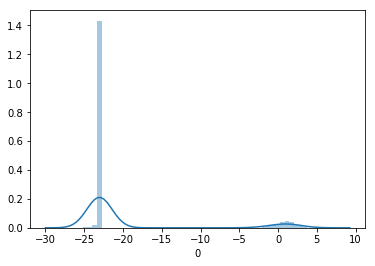

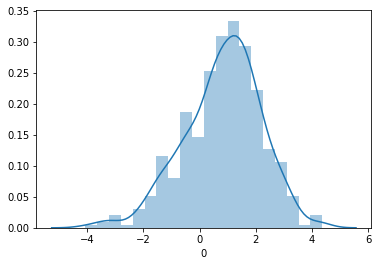

In [126]:
sns.distplot(null_importance['0'])
plt.show()
sns.distplot(null_importance[null_importance['0']>=-15]['0'])
plt.show()

In [127]:
col = null_importance[null_importance['0']>=-10]['index']

In [133]:
train_df_2 = train_df[col.tolist()+['jobflag']]

In [134]:
train_df_2['jobflag_2']=train_df_2['jobflag']-1
feature = train_df_2.drop(columns=['jobflag', 'jobflag_2']).columns
warnings.filterwarnings('ignore')
optimize_optuna = Optimize_by_Optuna(train_df_2, feature, 'jobflag_2')
study = optuna.create_study(direction='maximize')
study.optimize(optimize_optuna.objective, n_trials=40)
print(study.best_value)
print(study.best_params)

Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.984809	valid_1's multi_logloss: 1.08521
Early stopping, best iteration is:
[400]	training's multi_logloss: 0.993521	valid_1's multi_logloss: 1.08354
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 1.00288	valid_1's multi_logloss: 1.07803
Early stopping, best iteration is:
[392]	training's multi_logloss: 1.01317	valid_1's multi_logloss: 1.07463
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.99275	valid_1's multi_logloss: 1.02815
Early stopping, best iteration is:
[602]	training's multi_logloss: 0.983355	valid_1's multi_logloss: 1.0256
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.986143	valid_1's multi_logloss: 1.05808
Early stopping, best iteration is:
[468]	training's multi_logloss: 0.988897	valid_1's multi_logloss: 1.05704
Training until validatio

[I 2020-08-19 11:18:55,615] Finished trial#0 resulted in value: 0.3931478893004836. Current best value is 0.3931478893004836 with parameters: {'max_bin': 262, 'subsample': 0.4049765785332663, 'subsample_freq': 0.6115892859189909, 'learning_rate': 0.04339701152695447, 'num_leaves': 9, 'feature_fraction': 0.7118784840823205, 'bagging_freq': 4, 'min_child_samples': 73, 'lambda_l1': 0.0006329620038752194, 'lambda_l2': 0.0005113229038100231}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.803005	valid_1's multi_logloss: 0.97875
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.755198	valid_1's multi_logloss: 0.912701
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.794606	valid_1's multi_logloss: 0.917916
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.854162	valid_1's multi_logloss: 0.949686
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.850364	valid_1's multi_logloss: 0.998938


[I 2020-08-19 11:19:04,478] Finished trial#1 resulted in value: 0.5202911320261051. Current best value is 0.5202911320261051 with parameters: {'max_bin': 191, 'subsample': 0.41067598959907514, 'subsample_freq': 0.6788536959000997, 'learning_rate': 0.10054078963357249, 'num_leaves': 7, 'feature_fraction': 0.7685127479646744, 'bagging_freq': 1, 'min_child_samples': 33, 'lambda_l1': 0.0010289967253656858, 'lambda_l2': 0.00022423130280594422}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.830176	valid_1's multi_logloss: 0.969314
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.795549	valid_1's multi_logloss: 0.907408
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.798798	valid_1's multi_logloss: 0.916379
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.810371	valid_1's multi_logloss: 0.944512
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	training's multi_logloss: 0.762445	valid_1's multi_logloss: 0.981592


[I 2020-08-19 11:19:11,202] Finished trial#2 resulted in value: 0.525625755327882. Current best value is 0.525625755327882 with parameters: {'max_bin': 198, 'subsample': 0.4630647489111398, 'subsample_freq': 0.6167175864719194, 'learning_rate': 0.1676286927358713, 'num_leaves': 5, 'feature_fraction': 0.5790469202743597, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.0003156573996859692, 'lambda_l2': 0.003146771602064199}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's multi_logloss: 0.85934	valid_1's multi_logloss: 1.00947
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's multi_logloss: 0.917209	valid_1's multi_logloss: 1.01067
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.805373	valid_1's multi_logloss: 0.932587
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's multi_logloss: 0.844008	valid_1's multi_logloss: 0.975699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's multi_logloss: 0.920995	valid_1's multi_logloss: 1.01806


[I 2020-08-19 11:19:19,497] Finished trial#3 resulted in value: 0.4941550176064608. Current best value is 0.525625755327882 with parameters: {'max_bin': 198, 'subsample': 0.4630647489111398, 'subsample_freq': 0.6167175864719194, 'learning_rate': 0.1676286927358713, 'num_leaves': 5, 'feature_fraction': 0.5790469202743597, 'bagging_freq': 2, 'min_child_samples': 25, 'lambda_l1': 0.0003156573996859692, 'lambda_l2': 0.003146771602064199}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.733332	valid_1's multi_logloss: 0.950009
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's multi_logloss: 0.724705	valid_1's multi_logloss: 0.88209
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.759109	valid_1's multi_logloss: 0.893678
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.767297	valid_1's multi_logloss: 0.929117
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.777773	valid_1's multi_logloss: 0.960989


[I 2020-08-19 11:19:28,110] Finished trial#4 resulted in value: 0.5475510801576297. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.933114	valid_1's multi_logloss: 1.025
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.998584	valid_1's multi_logloss: 1.03976
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.979045	valid_1's multi_logloss: 1.00464
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.977105	valid_1's multi_logloss: 1.02999
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.942539	valid_1's multi_logloss: 1.02021


[I 2020-08-19 11:19:33,486] Finished trial#5 resulted in value: 0.4492957870853579. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	training's multi_logloss: 1.00322	valid_1's multi_logloss: 1.08094
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.977518	valid_1's multi_logloss: 1.06931
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.974176	valid_1's multi_logloss: 1.01182
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.987642	valid_1's multi_logloss: 1.0554
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.979842	valid_1's multi_logloss: 1.08725


[I 2020-08-19 11:19:40,509] Finished trial#6 resulted in value: 0.4014508368709193. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.836672	valid_1's multi_logloss: 0.994733
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's multi_logloss: 0.911871	valid_1's multi_logloss: 0.969911
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.84608	valid_1's multi_logloss: 0.929587
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's multi_logloss: 0.859018	valid_1's multi_logloss: 0.947542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[20]	training's multi_logloss: 0.896537	valid_1's multi_logloss: 0.998111


[I 2020-08-19 11:19:46,865] Finished trial#7 resulted in value: 0.510753759403468. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's multi_logloss: 0.80432	valid_1's multi_logloss: 0.986954
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[21]	training's multi_logloss: 0.834578	valid_1's multi_logloss: 0.910732
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's multi_logloss: 0.819243	valid_1's multi_logloss: 0.92354
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's multi_logloss: 0.792227	valid_1's multi_logloss: 0.950485
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's multi_logloss: 0.840012	valid_1's multi_logloss: 0.972139


[I 2020-08-19 11:19:54,465] Finished trial#8 resulted in value: 0.5281556919638629. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's multi_logloss: 0.811357	valid_1's multi_logloss: 0.972904
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.767493	valid_1's multi_logloss: 0.910315
Early stopping, best iteration is:
[372]	training's multi_logloss: 0.801874	valid_1's multi_logloss: 0.905152
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.760651	valid_1's multi_logloss: 0.930401
Early stopping, best iteration is:
[368]	training's multi_logloss: 0.794456	valid_1's multi_logloss: 0.922853
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.841512	valid_1's multi_logloss: 0.948938
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.842858	valid_1's multi_logloss:

[I 2020-08-19 11:20:06,003] Finished trial#9 resulted in value: 0.517993719970561. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.79385	valid_1's multi_logloss: 0.945214
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.79385	valid_1's multi_logloss: 0.945214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.83664	valid_1's multi_logloss: 0.902373
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	training's multi_logloss: 0.829057	valid_1's multi_logloss: 0.911652
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.82404	valid_1's multi_logloss: 0.92936
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.824384	valid_1's multi_logloss: 0.970956


[I 2020-08-19 11:20:19,447] Finished trial#10 resulted in value: 0.5355192061152769. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.839076	valid_1's multi_logloss: 0.958288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.869101	valid_1's multi_logloss: 0.919206
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.87488	valid_1's multi_logloss: 0.929421
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[238]	training's multi_logloss: 0.859662	valid_1's multi_logloss: 0.943252
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.850693	valid_1's multi_logloss: 0.976766


[I 2020-08-19 11:20:33,652] Finished trial#11 resulted in value: 0.5264447498624741. Current best value is 0.5475510801576297 with parameters: {'max_bin': 61, 'subsample': 0.8827197153587076, 'subsample_freq': 0.5074690657352035, 'learning_rate': 0.2775516548281099, 'num_leaves': 9, 'feature_fraction': 0.9302077579227445, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 4.181537620266634, 'lambda_l2': 6.8306700035549195}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.645608	valid_1's multi_logloss: 0.928321
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.559298	valid_1's multi_logloss: 0.857105
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.652811	valid_1's multi_logloss: 0.880556
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.65698	valid_1's multi_logloss: 0.902486
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.59475	valid_1's multi_logloss: 0.943409


[I 2020-08-19 11:20:47,377] Finished trial#12 resulted in value: 0.5643702381076751. Current best value is 0.5643702381076751 with parameters: {'max_bin': 50, 'subsample': 0.8966541262658317, 'subsample_freq': 0.4241683273684092, 'learning_rate': 0.2273771053550045, 'num_leaves': 9, 'feature_fraction': 0.981233944297284, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.7948531666754233, 'lambda_l2': 9.66989132749582}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's multi_logloss: 0.73927	valid_1's multi_logloss: 0.94125
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's multi_logloss: 0.701615	valid_1's multi_logloss: 0.869737
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's multi_logloss: 0.77067	valid_1's multi_logloss: 0.903831
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's multi_logloss: 0.757176	valid_1's multi_logloss: 0.923168
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[34]	training's multi_logloss: 0.757241	valid_1's multi_logloss: 0.968521


[I 2020-08-19 11:20:55,793] Finished trial#13 resulted in value: 0.5479518039459513. Current best value is 0.5643702381076751 with parameters: {'max_bin': 50, 'subsample': 0.8966541262658317, 'subsample_freq': 0.4241683273684092, 'learning_rate': 0.2273771053550045, 'num_leaves': 9, 'feature_fraction': 0.981233944297284, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.7948531666754233, 'lambda_l2': 9.66989132749582}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.756771	valid_1's multi_logloss: 0.950037
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[57]	training's multi_logloss: 0.69195	valid_1's multi_logloss: 0.878906
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.768958	valid_1's multi_logloss: 0.909931
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's multi_logloss: 0.74712	valid_1's multi_logloss: 0.936504
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's multi_logloss: 0.730715	valid_1's multi_logloss: 0.955595


[I 2020-08-19 11:21:04,524] Finished trial#14 resulted in value: 0.5487340538235786. Current best value is 0.5643702381076751 with parameters: {'max_bin': 50, 'subsample': 0.8966541262658317, 'subsample_freq': 0.4241683273684092, 'learning_rate': 0.2273771053550045, 'num_leaves': 9, 'feature_fraction': 0.981233944297284, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.7948531666754233, 'lambda_l2': 9.66989132749582}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.692404	valid_1's multi_logloss: 0.938301
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.640699	valid_1's multi_logloss: 0.866778
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	training's multi_logloss: 0.739205	valid_1's multi_logloss: 0.903119
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.686337	valid_1's multi_logloss: 0.913799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.73103	valid_1's multi_logloss: 0.947348


[I 2020-08-19 11:21:14,005] Finished trial#15 resulted in value: 0.5609771728470839. Current best value is 0.5643702381076751 with parameters: {'max_bin': 50, 'subsample': 0.8966541262658317, 'subsample_freq': 0.4241683273684092, 'learning_rate': 0.2273771053550045, 'num_leaves': 9, 'feature_fraction': 0.981233944297284, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.7948531666754233, 'lambda_l2': 9.66989132749582}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	training's multi_logloss: 0.776689	valid_1's multi_logloss: 0.98981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.848792	valid_1's multi_logloss: 0.95454
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.814997	valid_1's multi_logloss: 0.93089
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.848054	valid_1's multi_logloss: 0.948986
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.872467	valid_1's multi_logloss: 0.998906


[I 2020-08-19 11:21:21,620] Finished trial#16 resulted in value: 0.5197606306020426. Current best value is 0.5643702381076751 with parameters: {'max_bin': 50, 'subsample': 0.8966541262658317, 'subsample_freq': 0.4241683273684092, 'learning_rate': 0.2273771053550045, 'num_leaves': 9, 'feature_fraction': 0.981233944297284, 'bagging_freq': 3, 'min_child_samples': 6, 'lambda_l1': 0.7948531666754233, 'lambda_l2': 9.66989132749582}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.568954	valid_1's multi_logloss: 0.935596
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.522115	valid_1's multi_logloss: 0.857907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.659645	valid_1's multi_logloss: 0.880349
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.472534	valid_1's multi_logloss: 0.895524
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.59438	valid_1's multi_logloss: 0.948298


[I 2020-08-19 11:21:32,588] Finished trial#17 resulted in value: 0.5681285501584873. Current best value is 0.5681285501584873 with parameters: {'max_bin': 91, 'subsample': 0.5441397629517047, 'subsample_freq': 0.47976211375285766, 'learning_rate': 0.13341209122433276, 'num_leaves': 6, 'feature_fraction': 0.8458322978967301, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 0.05736451252159929, 'lambda_l2': 0.024205993524208113}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.572049	valid_1's multi_logloss: 0.927168
Early stopping, best iteration is:
[626]	training's multi_logloss: 0.522134	valid_1's multi_logloss: 0.923287
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.588987	valid_1's multi_logloss: 0.872455
Early stopping, best iteration is:
[554]	training's multi_logloss: 0.566485	valid_1's multi_logloss: 0.868223
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.586367	valid_1's multi_logloss: 0.885833
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.626007	valid_1's multi_logloss: 0.879562
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.585721	valid_1's multi_logloss: 0.885545
Early stopping, best iteration is:
[502]	training's multi_logloss: 0.584949	valid_1's multi_logloss: 0.885293
Training unt

[I 2020-08-19 11:21:46,190] Finished trial#18 resulted in value: 0.576265499370293. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's multi_logloss: 0.862655	valid_1's multi_logloss: 0.981242
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.816694	valid_1's multi_logloss: 0.930018
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.844895	valid_1's multi_logloss: 0.925977
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.810851	valid_1's multi_logloss: 0.928919
Early stopping, best iteration is:
[338]	training's multi_logloss: 0.842354	valid_1's multi_logloss: 0.925234
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	training's multi_logloss: 0.85692	valid_1's multi_logloss: 0.948457
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.864618	valid_1's multi_logloss: 

[I 2020-08-19 11:21:53,531] Finished trial#19 resulted in value: 0.5225733347012773. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.713054	valid_1's multi_logloss: 0.940418
[1000]	training's multi_logloss: 0.571936	valid_1's multi_logloss: 0.927042
Early stopping, best iteration is:
[940]	training's multi_logloss: 0.585056	valid_1's multi_logloss: 0.926095
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.726739	valid_1's multi_logloss: 0.884362
[1000]	training's multi_logloss: 0.585789	valid_1's multi_logloss: 0.865906
Early stopping, best iteration is:
[1027]	training's multi_logloss: 0.580078	valid_1's multi_logloss: 0.864672
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.726807	valid_1's multi_logloss: 0.894916
Early stopping, best iteration is:
[698]	training's multi_logloss: 0.660311	valid_1's multi_logloss: 0.886104
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.722165	val

[I 2020-08-19 11:22:12,363] Finished trial#20 resulted in value: 0.5637501249023096. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.606084	valid_1's multi_logloss: 0.923838
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.542065	valid_1's multi_logloss: 0.849904
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.63385	valid_1's multi_logloss: 0.861546
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.596557	valid_1's multi_logloss: 0.884211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.616826	valid_1's multi_logloss: 0.936033


[I 2020-08-19 11:22:22,895] Finished trial#21 resulted in value: 0.5714120487771012. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.744931	valid_1's multi_logloss: 0.949507
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.697784	valid_1's multi_logloss: 0.863528
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.750995	valid_1's multi_logloss: 0.906032
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[179]	training's multi_logloss: 0.726766	valid_1's multi_logloss: 0.916228
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.715814	valid_1's multi_logloss: 0.958397


[I 2020-08-19 11:22:32,019] Finished trial#22 resulted in value: 0.554293581071737. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.693396	valid_1's multi_logloss: 0.954793
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.671116	valid_1's multi_logloss: 0.874104
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.719457	valid_1's multi_logloss: 0.89256
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.741834	valid_1's multi_logloss: 0.909907
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.646074	valid_1's multi_logloss: 0.953792


[I 2020-08-19 11:22:39,588] Finished trial#23 resulted in value: 0.5622278733058492. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[280]	training's multi_logloss: 0.601862	valid_1's multi_logloss: 0.912674
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.485358	valid_1's multi_logloss: 0.862436
Early stopping, best iteration is:
[385]	training's multi_logloss: 0.547082	valid_1's multi_logloss: 0.853687
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[295]	training's multi_logloss: 0.607517	valid_1's multi_logloss: 0.870687
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.601447	valid_1's multi_logloss: 0.885092
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.465363	valid_1's multi_logloss: 0.945586
Early stopping, best iteration is:
[309]	training's multi_logloss: 0.57822	valid_1's multi_logloss: 

[I 2020-08-19 11:22:54,109] Finished trial#24 resulted in value: 0.5721847078956535. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[231]	training's multi_logloss: 0.7522	valid_1's multi_logloss: 0.955903
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.669821	valid_1's multi_logloss: 0.890427
Early stopping, best iteration is:
[376]	training's multi_logloss: 0.711639	valid_1's multi_logloss: 0.880044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.74137	valid_1's multi_logloss: 0.908881
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.786389	valid_1's multi_logloss: 0.92844
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.75065	valid_1's multi_logloss: 0.958765


[I 2020-08-19 11:23:14,655] Finished trial#25 resulted in value: 0.5382555329937019. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.750563	valid_1's multi_logloss: 0.945913
Early stopping, best iteration is:
[784]	training's multi_logloss: 0.688078	valid_1's multi_logloss: 0.939887
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.770032	valid_1's multi_logloss: 0.881272
[1000]	training's multi_logloss: 0.675081	valid_1's multi_logloss: 0.86541
Early stopping, best iteration is:
[972]	training's multi_logloss: 0.679067	valid_1's multi_logloss: 0.864746
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.77025	valid_1's multi_logloss: 0.897967
[1000]	training's multi_logloss: 0.671662	valid_1's multi_logloss: 0.893092
Early stopping, best iteration is:
[859]	training's multi_logloss: 0.693873	valid_1's multi_logloss: 0.889469
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.761241	valid_

[I 2020-08-19 11:23:43,153] Finished trial#26 resulted in value: 0.5589635218633348. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.727644	valid_1's multi_logloss: 0.945123
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.638532	valid_1's multi_logloss: 0.873217
Early stopping, best iteration is:
[411]	training's multi_logloss: 0.670253	valid_1's multi_logloss: 0.866851
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	training's multi_logloss: 0.723228	valid_1's multi_logloss: 0.906575
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.779905	valid_1's multi_logloss: 0.920895
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[234]	training's multi_logloss: 0.732744	valid_1's multi_logloss: 0.951626


[I 2020-08-19 11:23:53,484] Finished trial#27 resulted in value: 0.5496369686767458. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.569856	valid_1's multi_logloss: 0.93119
Early stopping, best iteration is:
[340]	training's multi_logloss: 0.650244	valid_1's multi_logloss: 0.923966
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.588929	valid_1's multi_logloss: 0.856807
Early stopping, best iteration is:
[588]	training's multi_logloss: 0.55249	valid_1's multi_logloss: 0.85559
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.582893	valid_1's multi_logloss: 0.891011
Early stopping, best iteration is:
[338]	training's multi_logloss: 0.66628	valid_1's multi_logloss: 0.887183
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.579329	valid_1's multi_logloss: 0.885632
Early stopping, best iteration is:
[445]	training's multi_logloss: 0.604243	valid_1's multi_logloss: 0.881555
Training until v

[I 2020-08-19 11:24:11,793] Finished trial#28 resulted in value: 0.569203160123662. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.792171	valid_1's multi_logloss: 0.960172
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[264]	training's multi_logloss: 0.783294	valid_1's multi_logloss: 0.898277
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.764238	valid_1's multi_logloss: 0.913599
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.786649	valid_1's multi_logloss: 0.933546
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.776539	valid_1's multi_logloss: 0.961632


[I 2020-08-19 11:24:21,854] Finished trial#29 resulted in value: 0.5343497314548276. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.993319	valid_1's multi_logloss: 1.0669
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.970326	valid_1's multi_logloss: 1.04861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[274]	training's multi_logloss: 0.958424	valid_1's multi_logloss: 1.01108
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[222]	training's multi_logloss: 0.963768	valid_1's multi_logloss: 1.04436
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.971839	valid_1's multi_logloss: 1.06086


[I 2020-08-19 11:24:28,853] Finished trial#30 resulted in value: 0.4170874913271111. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.593466	valid_1's multi_logloss: 0.92946
Early stopping, best iteration is:
[412]	training's multi_logloss: 0.634079	valid_1's multi_logloss: 0.925268
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.611719	valid_1's multi_logloss: 0.855189
Early stopping, best iteration is:
[592]	training's multi_logloss: 0.574576	valid_1's multi_logloss: 0.850862
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.606918	valid_1's multi_logloss: 0.888412
Early stopping, best iteration is:
[440]	training's multi_logloss: 0.63457	valid_1's multi_logloss: 0.884947
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.602823	valid_1's multi_logloss: 0.88352
Early stopping, best iteration is:
[490]	training's multi_logloss: 0.607168	valid_1's multi_logloss: 0.881533
Training until 

[I 2020-08-19 11:24:46,402] Finished trial#31 resulted in value: 0.5687404901310709. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.717442	valid_1's multi_logloss: 0.941477
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.642817	valid_1's multi_logloss: 0.858139
Early stopping, best iteration is:
[568]	training's multi_logloss: 0.619757	valid_1's multi_logloss: 0.852053
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.633271	valid_1's multi_logloss: 0.90489
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.709327	valid_1's multi_logloss: 0.893568
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.629977	valid_1's multi_logloss: 0.923722
Early stopping, best iteration is:
[306]	training's multi_logloss: 0.712601	valid_1's multi_logloss: 0.913891
Training until validation scores don't improve for 200 rounds
[500]	training's multi_log

[I 2020-08-19 11:24:59,911] Finished trial#32 resulted in value: 0.5657457811434811. Current best value is 0.576265499370293 with parameters: {'max_bin': 86, 'subsample': 0.6781844891290957, 'subsample_freq': 0.5741036147770283, 'learning_rate': 0.06226098621495584, 'num_leaves': 4, 'feature_fraction': 0.8308500801743306, 'bagging_freq': 2, 'min_child_samples': 5, 'lambda_l1': 0.06272213238829652, 'lambda_l2': 0.02989291065385534}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.51594	valid_1's multi_logloss: 0.91781
Early stopping, best iteration is:
[516]	training's multi_logloss: 0.508581	valid_1's multi_logloss: 0.917265
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.534553	valid_1's multi_logloss: 0.852353
Early stopping, best iteration is:
[448]	training's multi_logloss: 0.559336	valid_1's multi_logloss: 0.849772
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.529203	valid_1's multi_logloss: 0.872634
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.607163	valid_1's multi_logloss: 0.868755
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.52658	valid_1's multi_logloss: 0.891555
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.631546	valid_1's multi_logloss: 0.88653
Training until v

[I 2020-08-19 11:25:19,859] Finished trial#33 resulted in value: 0.576330387123468. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.744964	valid_1's multi_logloss: 0.944158
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.646988	valid_1's multi_logloss: 0.87221
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.724393	valid_1's multi_logloss: 0.863808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[272]	training's multi_logloss: 0.732198	valid_1's multi_logloss: 0.903929
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.756404	valid_1's multi_logloss: 0.913974
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.622533	valid_1's multi_logloss: 0.968846
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.694508	valid_1's multi_logloss: 

[I 2020-08-19 11:25:31,418] Finished trial#34 resulted in value: 0.549129206504456. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.64392	valid_1's multi_logloss: 0.917634
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.610191	valid_1's multi_logloss: 0.855112
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.686784	valid_1's multi_logloss: 0.873136
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.691843	valid_1's multi_logloss: 0.888065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	training's multi_logloss: 0.61887	valid_1's multi_logloss: 0.937427


[I 2020-08-19 11:25:42,158] Finished trial#35 resulted in value: 0.5742781081674153. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.697431	valid_1's multi_logloss: 0.94094
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.58222	valid_1's multi_logloss: 0.875256
Early stopping, best iteration is:
[320]	training's multi_logloss: 0.658685	valid_1's multi_logloss: 0.863493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.727768	valid_1's multi_logloss: 0.8935
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.724953	valid_1's multi_logloss: 0.914029
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.711102	valid_1's multi_logloss: 0.946321


[I 2020-08-19 11:25:53,699] Finished trial#36 resulted in value: 0.560466253212853. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.797339	valid_1's multi_logloss: 0.959433
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.689322	valid_1's multi_logloss: 0.901074
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.728861	valid_1's multi_logloss: 0.892386
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.780847	valid_1's multi_logloss: 0.918243
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.801272	valid_1's multi_logloss: 0.933287
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.776657	valid_1's multi_logloss: 0.967898


[I 2020-08-19 11:26:02,805] Finished trial#37 resulted in value: 0.5370499774179459. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.576972	valid_1's multi_logloss: 0.937441
Early stopping, best iteration is:
[436]	training's multi_logloss: 0.602993	valid_1's multi_logloss: 0.933875
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.59745	valid_1's multi_logloss: 0.865237
Early stopping, best iteration is:
[529]	training's multi_logloss: 0.586747	valid_1's multi_logloss: 0.862772
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.591918	valid_1's multi_logloss: 0.889352
Early stopping, best iteration is:
[339]	training's multi_logloss: 0.666326	valid_1's multi_logloss: 0.881471
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.587445	valid_1's multi_logloss: 0.899838
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.652579	valid_1's multi_logloss: 0.890079
Training unti

[I 2020-08-19 11:26:16,135] Finished trial#38 resulted in value: 0.574829424885039. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[146]	training's multi_logloss: 0.880138	valid_1's multi_logloss: 0.988449
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[255]	training's multi_logloss: 0.877421	valid_1's multi_logloss: 0.960498
Training until validation scores don't improve for 200 rounds
[500]	training's multi_logloss: 0.832626	valid_1's multi_logloss: 0.945849
Early stopping, best iteration is:
[323]	training's multi_logloss: 0.864424	valid_1's multi_logloss: 0.941975
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.853802	valid_1's multi_logloss: 0.945993
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.918872	valid_1's multi_logloss: 1.00877


[I 2020-08-19 11:26:23,687] Finished trial#39 resulted in value: 0.5067981267322595. Current best value is 0.576330387123468 with parameters: {'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}.


0.576330387123468
{'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215, 'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542}


In [136]:
train_df_2 = train_df[col.tolist()+['jobflag']]

In [139]:
X = train_df_2[col]
y = train_df_2['jobflag']-1

In [145]:
test_X = test_df[col]

In [172]:
PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
    'boosting_type': 'gbdt','objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'n_estimators': 500,
    
    'boost_from_average': False,'verbose': 250,'random_state':2020,
    'max_bin': 284, 'subsample': 0.8557428386486005, 'subsample_freq': 0.5951625089135864, 'learning_rate': 0.049314291762869215,
    'num_leaves': 7, 'feature_fraction': 0.8582139682982178, 'bagging_freq': 4, 'min_child_samples': 5, 
    'lambda_l1': 0.003582271159620405, 'lambda_l2': 1.2828770550671542
}
preds=[]
#importance=[]
for _ in tqdm(range(10)):
    train_set = lgb.Dataset(X, y)
        #val_set = lgb.Dataset(val_X, val_y)
    model = lgb.train(params=PARAMS, train_set=train_set,
                      valid_sets=train_set,
                      num_boost_round=3000,
                      #early_stopping_rounds=200, 
                      verbose_eval=500
                     )
    preds += [model.predict(test_X).tolist()]
#    score.append(metrics.f1_score(val_y,  np.argmax(preds, axis=1), average='macro'))
    #importance.append(model.feature_importance('gain'))
    PARAMS['random_state']+=1

[500]	training's multi_logloss: 0.55954
[500]	training's multi_logloss: 0.560287
[500]	training's multi_logloss: 0.557759
[500]	training's multi_logloss: 0.558944
[500]	training's multi_logloss: 0.558295
[500]	training's multi_logloss: 0.558546
[500]	training's multi_logloss: 0.558914
[500]	training's multi_logloss: 0.559457
[500]	training's multi_logloss: 0.558792
[500]	training's multi_logloss: 0.559604



In [174]:
sub = pd.read_csv('test.csv')

In [178]:
sub['preds'] = np.argmax(np.mean(preds, axis=0), axis=1)

In [180]:
sub['preds']+=1

In [183]:
sub.preds.value_counts(normalize=True)

3    0.582903
1    0.234653
4    0.137694
2    0.044750
Name: preds, dtype: float64